# Chapter 5. Polarized Spherical Harmonics
See also M-Sec. 6 and S-Sec. 5.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tabulate import tabulate
import polarsh as psh
psh.set_visoptions_vispy(title_size=12)

## 5.1. Spin-2 Spherical Harmonics
Construct `SphereGrid` and `SphereFrameField` objects where spin-2 SH basis will be evaluated.

RFBOutputContext()

[Keyboard interface]
A: hide/show global axes
[Keyboard interface]
A: hide/show global axes
G: hide/show sphere grids
F: show x(, y(, z)) axes for the frame field


CanvasBackend(css_width='600px')
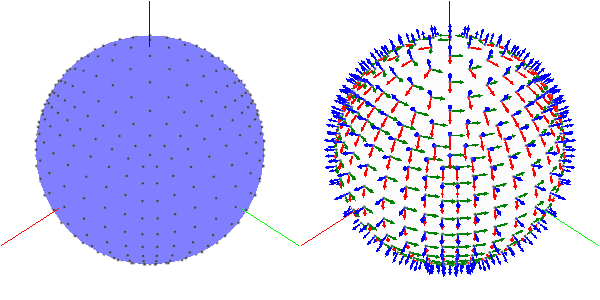

In [2]:
sphG = psh.SphereGridCube(10)
sphFF = sphG.ThetaPhiFrameField()
with psh.visualize_layout(1, 2, figsize=(600, 300)):
    sphG.visualize()
    sphFF.visualize(arrow_size=0.1)

Note that Stokes vector fields can be numerically described in several ways. Here, only consider $s_1$ and $s_2$ components (spin-2 Stokes vectors rather than full Stokes vectors) for simplicity.
1.  $\overset{\leftrightarrow}{f}:\hat{\mathbb S}^2 \to \mathcal{S}$, where $\mathcal{S}$ denotes the formally defined *Stokes space* using equivalence classes.
2.  $\left[f_1, f_2\right]^T:\vec{\mathbb F}^3 \to \mathcal{S}$ with a constraint that:
$$
\begin{bmatrix}
    f_1\left(\vec{\mathbf F}\mathbf R_z\left(\psi\right)\right) \\ f_2\left(\vec{\mathbf F}\mathbf R_z\left(\psi\right)\right)
\end{bmatrix} =
\begin{bmatrix}
    \cos 2\psi & \sin 2\psi \\ -\sin 2\psi & \cos 2\psi
\end{bmatrix} \begin{bmatrix}
    f_1\left(\vec{\mathbf F}\right) \\ f_2\left(\vec{\mathbf F}\right)
\end{bmatrix}
\text{, where }
\mathbf R_z\left(\psi\right) \coloneqq \begin{bmatrix}
    \cos\psi & - \sin\psi & 0 \\ \sin\psi & \cos\psi & 0 \\ 0 & 0 & 1
\end{bmatrix}.
\tag{variant of S-105}
$$
3. Fix a frame field, then $\left[f_1, f_2\right]^T:\hat{\mathbb S}^2 \to \mathbb{R}^2$ can describe a Stokes vector field.

While the first way is more suitable to understand Stokes vector fields as geometric (physical) objects, other ones are more close to what data is actually stored in our implementation. M-Eq. (26) proposes the third way to describe spin-2 SH basis functions with respect to a fixed $\theta\phi$-frame field.
$$
\begin{align}
{}_2Y_{lm}\left(\theta,\phi\right) &= \sqrt\frac{\left(l-2\right)!}{\left(l+2\right)!}\left[\alpha_{lm}\left(\theta\right)Y_{lm}\left(\theta,\phi\right)+\beta_{lm}\left(\theta\right)Y_{l-1,m}\left(\theta,\phi\right)\right], \tag{M-26a}\\
\alpha_{lm}\left(\theta\right) &= \frac{2m^2 -l\left(l+1\right)}{\sin^2\theta} - 2m \left(l-1\right) \frac{\cot\theta}{\sin\theta}+l\left(l-1\right)\cot^2\theta \tag{M-26b}\\
\beta_{lm}\left(\theta\right) &= 2\sqrt{\frac{2l+1}{2l-1}\left(l^2-m^2\right)}\left(\frac{m}{\sin^2 \theta} + \frac{\cot\theta}{\sin\theta}\right) \tag{M-26c}
\end{align}
$$

In [3]:
# ---------- Paramters ----------
level = 5 # We will evaluate basis fucntions up to 0 <= l < level

# ---------- Initialize variables ----------
N = psh.level2num(level, psh.DomType.UNI) # 25: number of basis functions
assert N == level**2

Ylm = sphG.SH_upto(level, False, psh.SHType.COMP) 
assert Ylm.shape == sphG.shape + (N,) # [*g, N], spin-2 (scalar) SH

theta, phi = sphG.theta_grid[..., None], sphG.phi_grid[..., None] 
assert (theta.shape == sphG.shape + (1,)) and (phi.shape == sphG.shape + (1,)) # [*g, 1]

l, m = psh.level2lms(level, psh.DomType.UNI, unstack=True)
assert (l.shape == (N,)) and (m.shape == (N,)) # Now Ylm, theta, phi, l, and m are broadcastable each other

# ---------- Evaluate spin-2 SH based on Eq. (M-26) ----------
assert sphG.ang_type == psh.AngType.RAD

sin = np.sin(theta)
sin2 = sin**2
cos = np.cos(theta)
cot = 1/np.tan(theta)
cot_over_sin = cot/sin

alpha = (2*(m**2)-l*(l+1))/sin2 - 2*m*(l-1)*cot_over_sin + l*(l-1)*(cot**2)
beta = 2*np.sqrt((2*l+1)/(2*l-1)*(l**2 - m**2)) * (m/sin2 + cot_over_sin)
factorial_ratio = np.reciprocal(((l-1)*l*(l+1)*(l+2)).astype(float)) # (l-2)!/(l+2)!

lm_ldown = psh.lms2idx(np.stack([l-1, m], -1), psh.DomType.UNI)
mask = np.abs(m)<=l-1
lm_ldown[~mask] = 0
Ylm_ldown = np.where(mask, Ylm[..., lm_ldown], 0) # Y_{l-1,m}

Ylm_s2 = np.sqrt(factorial_ratio ) * (alpha * Ylm + beta * Ylm_ldown)
Ylm_s2[..., l<2] = 0 # Ignore NaN for l=0 and 1
print(f"{Ylm_s2.shape = }, {Ylm_s2.dtype = }")

# ---------- Construct a `StokesField` object ----------
Stk = psh.comp2vec(Ylm_s2)
print(f"{Stk.shape = }, {Stk.dtype = }")

stkF_tp = psh.StokesField(sphFF, Stk)
print(f"{stkF_tp = }")

Ylm_s2.shape = (6, 10, 10, 25), Ylm_s2.dtype = dtype('complex128')
Stk.shape = (6, 10, 10, 25, 2), Stk.dtype = dtype('float64')
stkF_tp = StokesField[
  dom_type = <DomType.UNI: 0>,
  Stk.shape = [g:6, 10, 10 | c:25, | p:2],
]


C:\Users\class\AppData\Local\Temp\ipykernel_12608\83299295.py:28: RuntimeWarning: divide by zero encountered in reciprocal
  factorial_ratio = np.reciprocal(((l-1)*l*(l+1)*(l+2)).astype(float)) # (l-2)!/(l+2)!
C:\Users\class\AppData\Local\Temp\ipykernel_12608\83299295.py:35: RuntimeWarning: invalid value encountered in multiply
  Ylm_s2 = np.sqrt(factorial_ratio ) * (alpha * Ylm + beta * Ylm_ldown)


RFBOutputContext()

CanvasBackend(css_width='1500px')
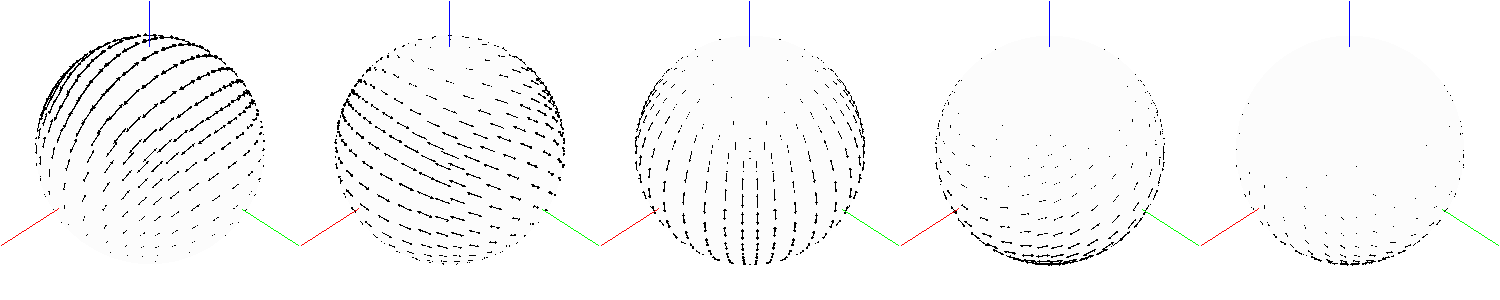

In [4]:
# ---------- Paramters ----------
level_show = 2
# ---------- Main ----------
cols = 2*level_show+1
with psh.visualize_layout(1, cols, figsize=(300*cols, 300)):
    for m in range(-level_show, level_show+1):
        stkF_tp.chan[psh.lms2idx([level_show, m], psh.DomType.UNI)].visualize(arrow_scale=0.3, help=False)

While this implementation is intuitive, it is not numerically stable. The implementation of spin-2 SH in `polarsh` is more close to the second way to describe Stokes vector fields, which utilize recurrence relation of Wigner D-functions, implemented in `spherical` package.

In [5]:
stkF_s2SH = psh.StokesField.from_s2SH_upto(level, sphFF)
assert (stkF_tp.SphFF is sphFF) and (stkF_s2SH.SphFF is sphFF)
assert np.allclose(stkF_s2SH.Stk, stkF_tp.Stk)

Note that `sphFF` does not matter in the sense of geometric quantities of Stokes vector fields, so that second argument of `psh.StokesField.from_s2SH_upto()` can be an instance of `psh.SphereGrid`. Then the method internally call `psh.SphereGrid.ThetaPhiFrameField.`

In [6]:
# ---------- Paramters ----------
l_show = 2
m_show = -2
# ---------- Main ----------
sphFF_geo = sphG.GeodesicFrameField()
stkF2 = psh.StokesField.from_s2SH_upto(level, sphFF_geo)
assert stkF2.SphFF is sphFF_geo
assert stkF_s2SH.allclose(stkF2)

sphFF_cube = sphG.CubemapFrameField()
stkF3 = psh.StokesField.from_s2SH_upto(level, sphFF_cube)
assert stkF3.SphFF is sphFF_cube
assert stkF_s2SH.allclose(stkF3)

stkF4 = psh.StokesField.from_s2SH_upto(level, sphG)
assert stkF4.SphFF is sphG.ThetaPhiFrameField() # Note that the result of `SphereGrid.ThetaPhiFrameField()` is cached
assert stkF_s2SH.allclose(stkF4)

## 5.2. Real & Complex Coefficients and Polarized Spherical Harmonics
Analogy: Fourier basis for $\left\{f:\left[0,1\right]^2 \to \mathbb R^2\right\}$ is $\left\{e^{2\pi i\left[j, k\right]^T\cdot \mathbf x}\left[1, 0\right]^T | j,k\in\mathbb Z\right\}\cup\left\{e^{2\pi i\left[j, k\right]^T\cdot \mathbf x}\left[0, 1\right]^T | j,k\in\mathbb Z\right\}$. Since the codomain of Stokes vector fields $\mathcal{S}$ is also a 2 dimensional vector space (in the sence of linear algebra, not physically *vector*), we need a pairs of spin-2 SH functions to span the space of Stokes vector fields with real-valued coefficients
$$
i\overset{\leftrightarrow}Y_{lm}:
$$

RFBOutputContext()

[Keyboard interface]
A: hide/show global axes


CanvasBackend(css_height='250px', css_width='1250px')
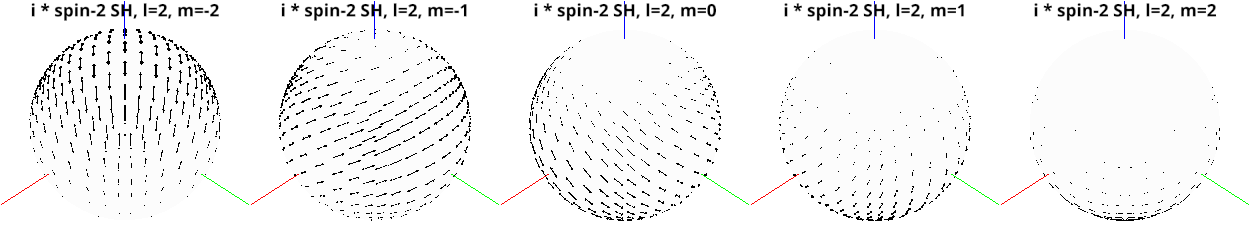

In [6]:
with psh.visualize_layout(1, 5, figsize=(1250, 250)):
    for m in range(-2, 3):
        idx_lm = psh.lms2idx([2, m], psh.DomType.UNI)
        (stkF_s2SH*1j).chan[idx_lm].visualize(arrow_scale=0.3, title=f"i * spin-2 SH, l=2, m={m}", help=(m == -2))

### Polarized spherical harmonics
$$
\begin{equation}\tag{variant of M-29, S-121, S-122}
\begin{split}
    \overset{\leftrightarrow}Y_{lm0} &\coloneqq Y_{lm} \oplus \overset\leftrightarrow 0 \oplus 0 \\
    \overset{\leftrightarrow}Y_{lm1} &\coloneqq 0 \oplus \overset\leftrightarrow Y_{lm} \oplus 0 \\
    \overset{\leftrightarrow}Y_{lm2} &\coloneqq 0 \oplus \left(i \overset\leftrightarrow Y_{lm}\right) \oplus 0 \\
    \overset{\leftrightarrow}Y_{lm3} &\coloneqq 0 \oplus \overset\leftrightarrow 0 \oplus Y_{lm} \\
\end{split}
\end{equation}
$$

In [7]:
# ---------- Paramters ----------
level = 4

# ---------- Main ----------
scalF_SH = psh.ScalarField.from_SH_upto(level, sphG, psh.SHType.REAL) # scalar/spin-0 SH
print(f"{scalF_SH = }")
stkF_s2SH = psh.StokesField.from_s2SH_upto(level, sphG) # spin-2 SH
print(f"{stkF_s2SH = }")

stkF_PSH = psh.StokesField.from_PSH_upto(level, sphG) # polarized SH, mixed usage of spin-0 and 2 SH
print(f"{stkF_PSH = }")

print("\n# Check")
for idx, (l, m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
    for p in range(4):
        # print(f"[{l=}, {m=}, {p=}]", end=" ")
        PSH_Stk_curr = stkF_PSH.chan[idx, p].Stk # A Stokes vcector field for a PSH basis for fixed l, m, p
        if p == 0:
            assert np.allclose(PSH_Stk_curr[..., 0], scalF_SH.fval[..., idx])
            assert np.allclose(PSH_Stk_curr[..., 1:], 0)
        elif p == 1:
            assert np.allclose(PSH_Stk_curr[..., 1:3], stkF_s2SH.Stk[..., idx, :])
            assert np.allclose(PSH_Stk_curr[..., (0, 3)], 0)
        elif p == 2:
            assert np.allclose(PSH_Stk_curr[..., 1:3], (stkF_s2SH * 1j).Stk[..., idx, :])
            assert np.allclose(PSH_Stk_curr[..., (0, 3)], 0)
        else:
            assert np.allclose(PSH_Stk_curr[..., 3], scalF_SH.fval[..., idx])
            assert np.allclose(PSH_Stk_curr[..., :3], 0)
    # print()
print("Clear!")

scalF_SH = ScalarField[
  dom_type = <DomType.UNI: 0>,
  fval.shape = [g:6, 10, 10 | c:16,],
]
stkF_s2SH = StokesField[
  dom_type = <DomType.UNI: 0>,
  Stk.shape = [g:6, 10, 10 | c:16, | p:2],
]
stkF_PSH = StokesField[
  dom_type = <DomType.UNI: 0>,
  Stk.shape = [g:6, 10, 10 | c:16, 4 | p:4],
]

# Check
Clear!


### PSH coefficient vector

RFBOutputContext()

[Keyboard interface]
0: texture/point cloud mode for s0 component
A: hide/show global axes


CanvasBackend(css_height='500px')
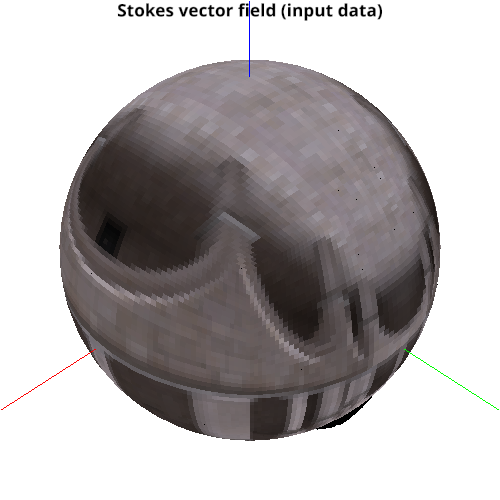

In [8]:
stkF = psh.StokesField.from_cubeimage(psh.data_dir/"sponza_64_s%d.exr")
stkF.visualize(title="Stokes vector field (input data)")

In [9]:
level = 5
shv = stkF.SHCoeff(level)

### Real & complex coefficients representation
$$
\begin{equation}\nonumber
\begin{split}
\left({\mathrm f}_{lm1} + {\mathrm f}_{lm2}i\right) = \left\langle {\overset\leftrightarrow Y}_{lm}, \overset\leftrightarrow f \right\rangle_{\mathcal F | \mathbb C} &= \left\langle {\overset\leftrightarrow Y}_{lm}, \overset\leftrightarrow f \right\rangle_{\mathcal F} + i \left\langle {i \overset\leftrightarrow Y}_{lm}, \overset\leftrightarrow f \right\rangle_{\mathcal F} \\
&= \left\langle {\overset\leftrightarrow Y}_{lm1}, \overset\leftrightarrow f \right\rangle_{\mathcal F} + i \left\langle {\overset\leftrightarrow Y}_{lm2}, \overset\leftrightarrow f \right\rangle_{\mathcal F}
\end{split}
\end{equation},
$$
i.e.,
$$
\begin{align}
{\mathrm f}_{lm1} &= \left\langle {\overset\leftrightarrow Y}_{lm1}, \overset\leftrightarrow f \right\rangle_{\mathcal F} \nonumber\\
{\mathrm f}_{lm2} &= \left\langle {\overset\leftrightarrow Y}_{lm2}, \overset\leftrightarrow f \right\rangle_{\mathcal F} \nonumber
\end{align}
$$

In [10]:
scalF_SH = psh.ScalarField.from_SH_upto(level, stkF.SphGrid, psh.SHType.REAL) # scalar/spin-0 SH
stkF_s2SH = psh.StokesField.from_s2SH_upto(level, stkF.SphGrid) # spin-2 SH
for idx, (l, m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
    assert np.allclose(shv.coeff[:, idx, 0], scalF_SH.chan[idx].inner(stkF.s0_ScalarField()))
    
    assert np.allclose(shv.coeff[:, idx, 1], stkF_s2SH.chan[idx].inner(stkF.s12_StokesField()))
    assert np.allclose(shv.coeff[:, idx, 2], (stkF_s2SH*1j).chan[idx].inner(stkF.s12_StokesField()))
    inner_comp = stkF_s2SH.chan[idx].inner_comp(stkF.s12_StokesField())
    assert np.allclose(psh.vec2comp(shv.coeff[:, idx, 1:3]), inner_comp)
    
    assert np.allclose(shv.coeff[:, idx, 3], scalF_SH.chan[idx].inner(stkF.s3_ScalarField()))
print("Clear!")

Clear!


In [11]:
stkF_PSH = psh.StokesField.from_PSH_upto(level, stkF.SphGrid) # polarized SH
for idx, (l, m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
    for p in range(4):
        assert np.allclose(shv.coeff[:, idx, p], stkF_PSH.chan[idx, p].inner(stkF))
print("Clear!")

Clear!


$$
\begin{align}
\overset\leftrightarrow f &= \sum_{l,m}\left({\mathrm f}_{lm1} + {\mathrm f}_{lm2}i\right) {\overset\leftrightarrow Y}_{lm} \tag{M-33} \\
&= \sum_{l,m} {\mathrm f}_{lm1} {\overset\leftrightarrow Y}_{lm1} + {\mathrm f}_{lm2} {\overset\leftrightarrow Y}_{lm2} \tag{M-34}
\end{align}
$$

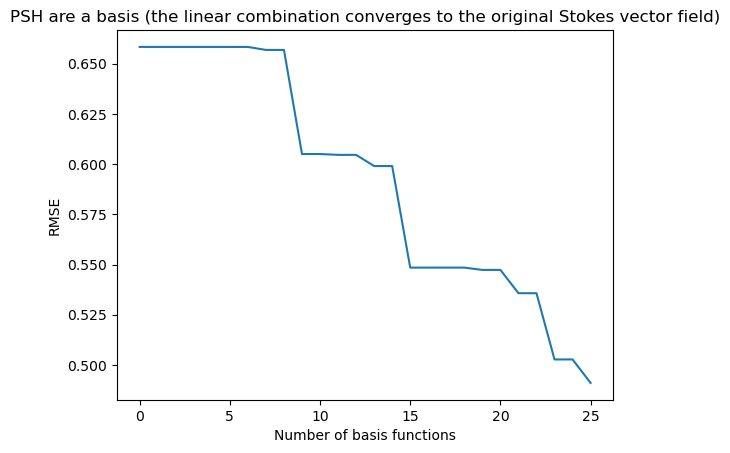

In [12]:
# real & complex coefficients representations are for s1 and s2 components
# We cut `stkF` to a spin-2 Stokes vector field to focus on the difference between each representation.
stkF_s2 = stkF.to_CodType(psh.CodType.POLAR2)
stkF_PSH_s2 = stkF_PSH.to_CodType(psh.CodType.POLAR2)
stkF_accum = psh.StokesField.zeros_like(stkF_s2)

loss = [psh.rms(stkF_s2.Stk)]
for idx, (l,m) in enumerate(psh.level2lms(level, psh.DomType.UNI)):
    s2SH_weighted = stkF_s2SH.chan[idx].chan * psh.vec2comp(shv.coeff[:, idx, 1:3])
    assert s2SH_weighted.allclose(stkF_PSH_s2.chan[idx, 1].chan * shv.coeff[:, idx, 1] + \
                                  stkF_PSH_s2.chan[idx, 2].chan * shv.coeff[:, idx, 2])
    stkF_accum += s2SH_weighted
    loss.append(psh.rms((stkF_s2 - stkF_accum).Stk))

plt.plot(range(idx+2), loss)
plt.xlabel("Number of basis functions"); plt.ylabel("RMSE")
plt.title("PSH are a basis (the linear combination converges to the original Stokes vector field)");

## 5.3. PSH coefficient matrices and isotropic pBRDFs

In PSH domain, a linear operator $T:\mathcal F\left(\hat{\mathbb S}^2, \mathcal S\right)\to \mathcal F\left(\hat{\mathbb S}^2, \mathcal S\right)$ can be represented as a PSH coefficient matrix defined by:
$$\tag{M-40}
\mathrm{T}_{l_om_op_o, l_im_ip_i} = \left\langle {\overset\leftrightarrow Y}_{l_om_op_o}, T\left[{\overset\leftrightarrow Y}_{l_im_ip_i}\right] \right\rangle_{\mathcal F}.
$$
For PSH coefficient matrices, we visualize it into $4\times 4$ submatrices for each $p_o$ and $p_i$. Note that `psh.SHMat.tabulate()` report coefficients in $\left(l,m\right)$-major order, but `psh.SHMat.matshow()` shows them in $p$-major order.

The following example is the PSH coefficient matrix of a rotation.

SHMat.coeff[None,:,:,:,:]
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
l,m,p       0,0,0      0,0,1     0,0,2     0,0,3     1,-1, 0     1,-1, 1     1,-1, 2     1,-1, 3     1,0,0      1,0,1     1,0,2     1,0,3     1,1,0      1,1,1      1,1,2     1,1,3     2,-2, 0     2,-2, 1     2,-2, 2     2,-2, 3     2,-1, 0     2,-1, 1     2,-1, 2     2,-1, 3      2,0,0      2,0,1      2,0,2      2,0,3      2,1,0      2,1,1      2,1,2      2,1,3      2,2,0      2,2,1      2,2,2      2,2,3
-------  --------  ---------  --------  --------  ----------  ----------  ----------  ----------  --------  ---------  --------  --------  --------  ---------

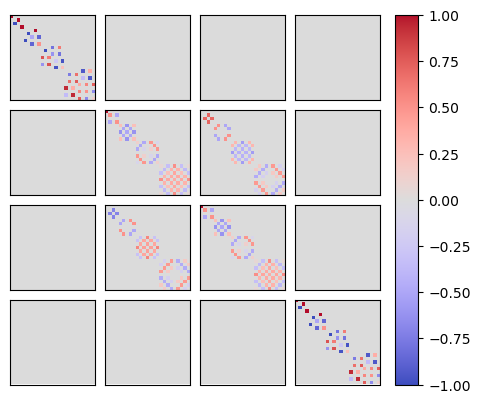

In [13]:
rotvec = [np.pi/2, 0, 0]
shm_rot = psh.SHMat.from_rotation(rotvec, level, 4, psh.SHType.REAL) # `4` or `"POLAR4"` is a shorthand of `psh.CodType.POLAR4`
print(shm_rot.cut(3).tabulate())
shm_rot.matshow();

### PSH coefficient matrices of isotropic pBRDFs

Construct a `psh.MuellerField` object. Here we use [[Seung-Hwan Baek et al. 2020]](https://vclab.kaist.ac.kr/siggraph2020/index.html)'s measured pBRDF. This dataset consists of pBRDF at $361 \times 91 \times 91$ samples from $\left(\phi_d,\theta_d,\theta_h\right)$ Rusinkiewicz coordinates space. Our data directory `psh.data_dir` already includes a downsampled ($73\times 19 \times 19$) example of the dataset.

In [14]:
muelF = psh.MuellerField.from_SB20(psh.data_dir/f"6_gold_pbrdf_dsamp5.mat", psh.data_dir/f"pbrdf_table_info_dsamp5.mat")
print(muelF)

MuellerField[
  dom_type = <DomType.ISOBI: 2>,
  M.shape = [g:73, 19, 19 | c:3, | p:4, 4],
]


`psh.MuellerField.SHCoeff`: Get the PSH coefficient matrix for a pBRDF: 3.7468 sec.
SHMat[c: 3, | N: 1240 | p: 4, 4][
  level = 10,
  dom_type = <DomType.ISOBI2: 3>,
  cod_type = <CodType.POLAR4: 4>,
  sh_type = <SHType.REAL: 0>,
  coeff.shape = (3, 1240, 4, 4),
  coeff.dtype = float64,
]


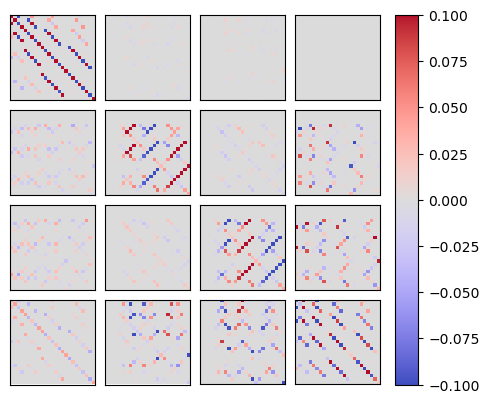

In [15]:
level = 10
with psh.Tictoc("`psh.MuellerField.SHCoeff`: Get the PSH coefficient matrix for a pBRDF: %.4f sec."):
    shm_brdf = muelF.SHCoeff(10, allow_nan=True)
print(shm_brdf)

# ---------- Visualize ----------
norm = mcolors.Normalize(-0.1, 0.1)
shm_brdf.matshow(0, level_show=5, norm=norm); # `0` for RED channel

### Sparsity of pBRDF coefficients
$$\tag{M-52}
\mathrm{P}_{l_om_op_o, l_im_ip_i} = 0 \text{, if }\left|m_i\right|\ne \left|m_o\right|,
$$

Using `psh.level2lms` we get $\left(l,m\right)$ indices for isotropic pBRDFs. Note that `shm_brdf` stores the coefficient matrix with indices of `li, lo, mi, mo` in the following.

When `shm_brdf.matshow()` have been called, the index order will be internally changed and zero values will be filled for abscent indices in `li, lo, mi, mo`.

In [16]:
level = shm_brdf.level
dom_type = shm_brdf.dom_type

li, lo, mi, mo = psh.level2lms(level, dom_type, unstack=True)
coeff_red_p00 = shm_brdf.coeff[0, :, 0, 0] # Show only red channel, p_i=p_o=0 for simplicity
print(tabulate(np.stack([li, lo, mi, mo, coeff_red_p00], -1), headers=['li', 'lo', 'mi', 'mo', 'pBRDF value']))
assert shm_brdf.N == len(li)

  li    lo    mi    mo    pBRDF value
----  ----  ----  ----  -------------
   0     0     0     0    0.186286
   0     1     0     0    0.179152
   1     0     0     0   -0.188139
   1     1    -1    -1    0.161547
   1     1    -1     1    0.000806865
   1     1     0     0   -0.218255
   1     1     1    -1   -0.000806865
   1     1     1     1    0.161547
   0     2     0     0    0.0346406
   2     0     0     0    0.0470143
   1     2    -1    -1    0.151011
   1     2    -1     1    0.00159737
   1     2     0     0   -0.112709
   1     2     1    -1   -0.00159737
   1     2     1     1    0.151011
   2     1    -1    -1   -0.163001
   2     1    -1     1   -0.00144611
   2     1     0     0    0.126761
   2     1     1    -1    0.00144611
   2     1     1     1   -0.163001
   2     2    -2    -2    0.151101
   2     2    -2     2    0.000665932
   2     2    -1    -1   -0.19213
   2     2    -1     1   -0.00284759
   2     2     0     0    0.185521
   2     2     1    -1    0.0

$$
\begin{equation}\tag{M-53}
\begin{split}
    \tilde{\mathrm{P}}_{l_om_op_o, l_im_ip_i,\mathrm{iso}} &= 0 \text{, if }m_i\ne m_o, \\
    \tilde{\mathrm{P}}_{l_om_op_o, l_im_ip_i,\mathrm{conj}} &= 0 \text{, if }m_i\ne -m_o.
\end{split}
\end{equation}
$$

In [17]:
iso, conj = psh.mat2comppair(shm_brdf.coeff[..., 1:3, 1:3])
assert np.allclose(iso[..., mi != mo], 0)
assert np.allclose(conj[..., mi != -mo], 0)
print("Clear!")

Clear!


### Validate isotropy

In [18]:
level_test = 7
shm_brdf_ = shm_brdf.cut(level_test).to_domtype("UNI")

In [19]:
for psi in [0.1, 0.2, np.pi/4, np.pi/2, np.pi, 3*np.pi/2]:
    rotvec = np.array([0, 0, psi])
    shm_brdf_rot = shm_brdf_.apply_rotation(rotvec)

    # Check implementation of `psh.SHMat.apply_rotation`
    R = psh.SHMat.from_rotation(rotvec, level_test, shm_brdf.cod_type, shm_brdf.sh_type)
    assert shm_brdf_rot.allclose(R @ shm_brdf_ @ R.adjoint())
    
    # Check rotational symmetry around z-axis
    assert shm_brdf_.allclose(shm_brdf_rot)
print("Clear!")

Clear!
